# ***Examen práctico parical 2***
### Luis Eduardo Jiménez del Muro - 23/02/2025
---

# **Paqueterías**

In [ ]:
# Paqueterías
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import discriminant_analysis, neighbors, linear_model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', '{:,.4f}'.format)

# **Funciones**

## *Funciones para gráficas*

In [2]:
# Gráfica de calibracion
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop') + 1
    grouped = df_calibracion.groupby('bins').mean()
    auc = roc_auc_score(y_score=predicciones, y_true=y)
    
    # Gráfica
    plt.figure(figsize=(7,5))
    plt.plot(grouped['predicciones'], grouped['predicciones'], label='Real', color='red', lw=1.5)
    plt.plot(grouped['predicciones'], grouped['y'], label='Modelo', marker='o', color='cadetblue', ms=5, lw=2)
    plt.title(f'Calibración del modelo \n\n$AUC={auc:.4f}$', fontsize=16, fontweight='bold')
    plt.grid(alpha=0.3, ls='--')
    plt.legend()
    plt.show()
    

# Gráfica de scatterplots
def scatterplots(data, target, numeric_features):
    num_vars = len(numeric_features) 

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.tight_layout(pad=5)
    fig.suptitle('Scatterplots', fontsize=20, fontweight='bold', y=1)

    for i, ax in enumerate(axes.flat):
        if i < num_vars:
            ax.scatter(data[numeric_features[i]], data[target], marker='o', color='cadetblue', s=10, alpha=0.05)
            ax.set_title(f'{numeric_features[i]} vs {target}', fontsize=12, fontweight='bold')
            ax.set_xlabel(numeric_features[i])
            ax.set_ylabel(target)
            ax.grid(alpha=0.3, ls='--')
        else:
            ax.remove()

    plt.show()


# Gráfica de análsisi bivariado
def bivariado(data, target, numeric_features):
    num_vars = len(numeric_features)

    df_bivariado = data.copy()

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.tight_layout(pad=5)
    fig.suptitle('Análisis Bivariado', fontsize=20, fontweight='bold', y=1)

    for i, ax in enumerate(axes.flat):
        if i < num_vars:
            df_bivariado[f'{numeric_features[i]}_bins'] = pd.qcut(df_bivariado[numeric_features[i]], q=10, labels=False, duplicates='drop') + 1
            grouped_data = df_bivariado.groupby(f'{numeric_features[i]}_bins').mean()
                
            ax.plot(grouped_data[numeric_features[i]], grouped_data[target], marker='o', color='cadetblue', lw=1, markersize=4)
            ax.set_title(numeric_features[i], fontsize=12, fontweight='bold')
            ax.set_xlabel(numeric_features[i])
            ax.set_ylabel(target)
            ax.grid(alpha=0.3, ls='--')
        else:
            ax.remove() # Eliminar subplots vacíos
            
    plt.show()


# Histogramas de frecuencia
def histogramas(data, numeric_features):
    num_vars = len(numeric_features)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.tight_layout(pad=3)
    fig.suptitle('Histogramas de Frecuencia', fontsize=20, fontweight='bold', y=1)


    for i, ax in enumerate(axes.flat):
        if i < num_vars:
            sns.histplot(data[numeric_features[i]],  color="cadetblue", kde=True, ax=ax, bins=50,  edgecolor=None)
            ax.set_title(numeric_features[i], fontsize=12, fontweight='bold')
            ax.grid(alpha=0.3, ls='--')
        else:
            ax.remove() # Eliminar subplots vacíos

    plt.show()


# Gráfica de AUC para cada número de vecinos en KNN
def graph_knn(X_train, X_test, y_train, y_test, n_neighbors):
    vecinos = []
    auc = []

    # Escalado de datos
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for i in range(1, n_neighbors+1):
        model = neighbors.KNeighborsClassifier(n_neighbors=i).fit(X_train_scaled, y_train)
        probabilidades = model.predict_proba(X_test_scaled)[:,1]
        vecinos.append(i)
        auc.append(roc_auc_score(y_score=probabilidades, y_true=y_test))

    resultados = pd.DataFrame({'nn':vecinos, 'auc': auc})
    max_auc = resultados[resultados['auc'] == resultados.max()['auc']][['nn', 'auc']]

    plt.figure(figsize=(7, 5))
    plt.title(f'Número de vecinos óptimo = {max_auc["nn"].values[0]:.0f}', fontsize=16, fontweight='bold')
    plt.plot(resultados['nn'], resultados['auc'], color='cadetblue',lw=1.5, marker='o', ms=3, label='Otros Puntos')
    plt.scatter(max_auc['nn'], max_auc['auc'], marker='*', color='red',zorder=2, s=50, label='Max AUC')
    plt.grid(alpha=0.3, ls='--')
    plt.ylabel('AUC')
    plt.xlabel('Número de Vecinos')
    plt.legend(loc='best')
    plt.show()


# Histograma
def histograma(probabilidades, y):
    resultados = pd.DataFrame({'y':y, 'probabilidades': probabilidades})
    plt.figure(figsize=(7,5))
    sns.histplot(resultados[resultados['y'] == 0]['probabilidades'], stat='density', color='seagreen', alpha=0.40, kde=True, bins=50, edgecolor=None, label='0')
    sns.histplot(resultados[resultados['y'] == 1]['probabilidades'], stat='density', color='cadetblue', alpha=0.65, kde=True, bins=50, edgecolor=None, label='1')
    plt.title('Histograma de probabilidades', fontsize=16, fontweight='bold')
    plt.legend(loc='best')
    plt.xlabel('Probabilidades')
    plt.ylabel('Frecuencia')
    plt.grid(alpha=0.3, ls='--')
    plt.show()


# ROC Curve
def roc_curve_graph(probabilidades, y):
    fpr, fpn, scores = roc_curve(y_score=probabilidades, y_true=y)
    plt.figure(figsize=(7,5))
    plt.title('ROC Curve', fontsize=16, fontweight='bold')
    plt.plot(fpr, fpn, label='Modelo', color='cadetblue', lw=2)
    plt.plot([0, 1], [0, 1], label='Real', color='red', lw=1.5)
    plt.xlabel("1-specificty")
    plt.ylabel("sensitivity")
    plt.legend(loc='best')
    plt.grid(alpha=0.3, ls='--')
    plt.show()


# Plotear resultados
def plot_results(probabilidades, y, bins):
    calibracion(probabilidades, y, bins)
    histograma(probabilidades, y)
    roc_curve_graph(probabilidades, y)

## *Funciones de ajuste de modelos y resultados*

In [3]:
def guardar_resultado(nombre_modelo, auc, lista_modelos, lista_auc):
    lista_modelos.append(nombre_modelo)
    lista_auc.append(auc)


# Ajustar modelo KNN
def knn_classifier(X_train, X_test, y_train, y_test, n_neighbors_opt):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = neighbors.KNeighborsClassifier(n_neighbors_opt).fit(X_train_scaled, y_train)
    probabilidades_knn = model.predict_proba(X_test_scaled)[:,1]
    auc = roc_auc_score(y_score=probabilidades_knn, y_true=y_test)
    return probabilidades_knn, auc


# Ajustar regresión logística
def logistic(X_train, y_train, X_test, y_test, degree):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly_features', PolynomialFeatures(degree=degree, include_bias=False)),
        ('model', linear_model.LogisticRegression(penalty='l2'))
    ])

    pipeline.fit(X_train, y_train)
    probabilidades_logistic_poly = pipeline.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_score=probabilidades_logistic_poly, y_true=y_test)
    coef = pipeline.named_steps['model'].coef_
    variables = pipeline.named_steps['poly_features'].get_feature_names_out(X_train.columns)
    return probabilidades_logistic_poly, auc, coef, variables


# Ajustar modelo de discriminante lineal
def discriminante(X_train, y_train, X_test, y_test):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', discriminant_analysis.LinearDiscriminantAnalysis())
    ])
    pipeline.fit(X_train, y_train)
    probabilidades_modelo_disc = pipeline.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_score=probabilidades_modelo_disc, y_true=y_test)
    return probabilidades_modelo_disc, auc


# Ajustar modelo de red neuronal
def neural_network(X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures()),
        ('nn', MLPRegressor())
    ])
    params_grid = {
        'poly__degree': [1, 2],
        'nn__hidden_layer_sizes': [(5, 5, 5), (10, 10, 10), (20, 20, 20), (50, 50), (100, )],
        'nn__activation': ['tanh', 'relu', 'logistic'],
        'nn__alpha': [0.1, 0.01]
    }
    grid_search = GridSearchCV(pipeline, param_grid=params_grid, cv=5, scoring='roc_auc', n_jobs=-1).fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    probabilidades = best_model.predict(X_test)
    auc = roc_auc_score(y_score=probabilidades, y_true=y_test)
    return probabilidades, auc

# **Descripción del dataset**

+ `gender`: Variable categórica del género del paciente:
    + Female
    + Male
    + Other

+ `age`: Variable numérica con la edad del paciente.

+ `hypertension`: Variable binaria que indica si el paciente presenta hipertensión o no.

+ `heart_disease`: Variable binaria que indica si el paciente presenta enfermedades cardiacas.

+ `smoking_history`: Variable categórica con el historial de los fumadores.
    + never
    + No Info
    + current
    + former
    + ever
    + not current

+ `bmi`: Variable numérica que indica el índice de masa corporal.

+ `diabetes`: Variable binaria que indica si el paciente tiene o no diabetes (variable objetivo).

# **Análisis Exploratorio**

## *Limpieza del dataset*

In [4]:
data = pd.read_csv('data/diabetes.csv')
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,diabetes
0,Female,80.0000,0,1,never,25.1900,0
1,Female,54.0000,0,0,No Info,27.3200,0
2,Male,28.0000,0,0,never,27.3200,0
3,Female,36.0000,0,0,current,23.4500,0
4,Male,76.0000,1,1,current,20.1400,0


In [5]:
data['gender'].unique(), data['smoking_history'].unique()

(array(['Female', 'Male', 'Other'], dtype=object),
 array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
       dtype=object))

In [6]:
data.isna().sum()

gender             0
age                0
hypertension       0
heart_disease      0
smoking_history    0
bmi                0
diabetes           0
dtype: int64

In [7]:
data = pd.get_dummies(data)

target = 'diabetes'
X = data.drop(target, axis=1)
y = data[target]

numeric_features = [col for col in X.columns if X[col].dtype in ['float64']]
categorical_features = [col for col in X.columns if X[col].dtype not in ['float64']]

## *Visualización de los datos*

### Scatterplots contra el target

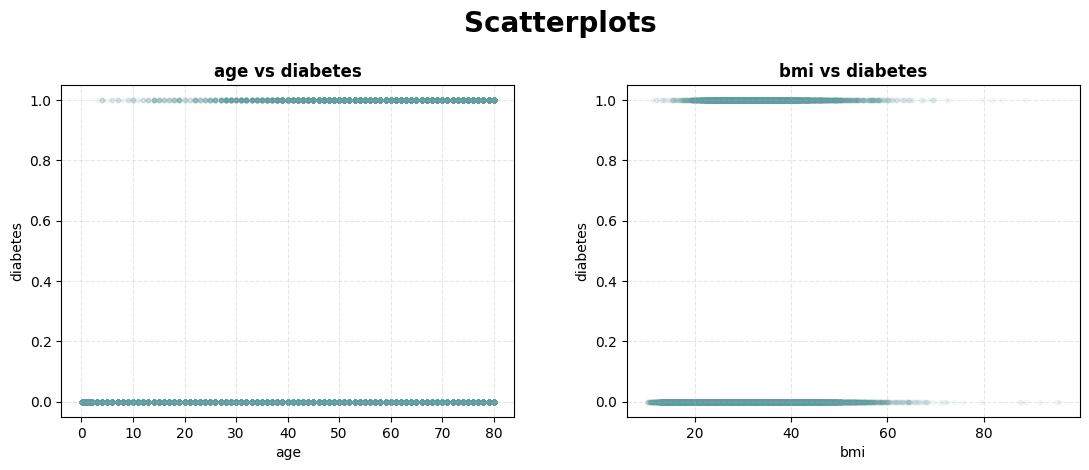

In [8]:
scatterplots(data, target, numeric_features)

+ Existe diabetes en pacientes de prácticamente todas las edades, sin embargo, se vuelve más presente a partir de entre los 15 y 20 años.

+ No es posible identificar una diferencia clara de pacientes con y sin diabetes dependiendo del indice de masa corporal.

### Análisis bivariado

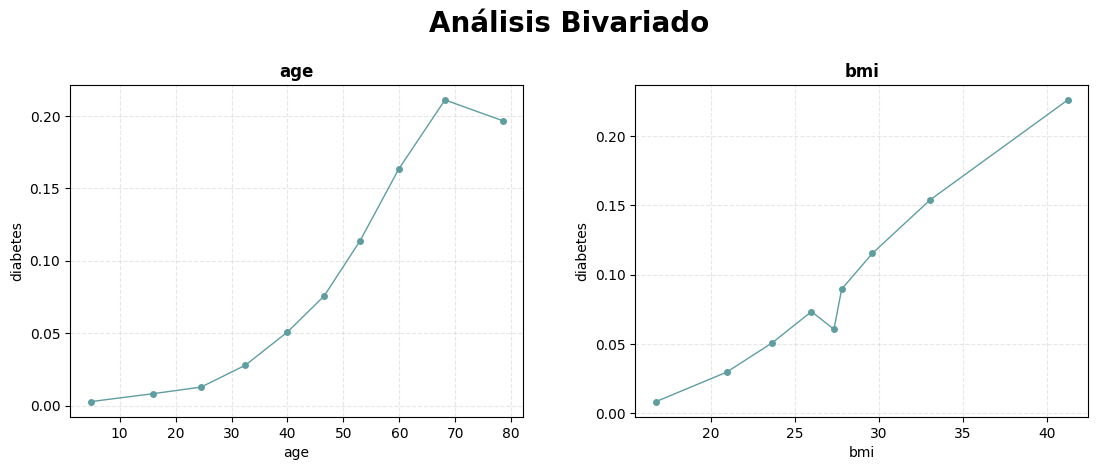

In [9]:
bivariado(data, target, numeric_features)

+ Observamos de manera mas clara que la probabilidad de tener diabetes aumenta en forma exponencialmente conforme la edad avanza. Sin embargo, es importante notar que hay un salto raro hacia abajo en el bin de de entre los 70 y 80 años, lo que significa que al ser 80 años la edad máxima registrada haya una mayor acumulación de datos.

+ Gracias al vibariado nos damos cuenta que si hay una relación creciente casi lineal entre el índice de masa corporal y la diabetes. 

### Histogramas

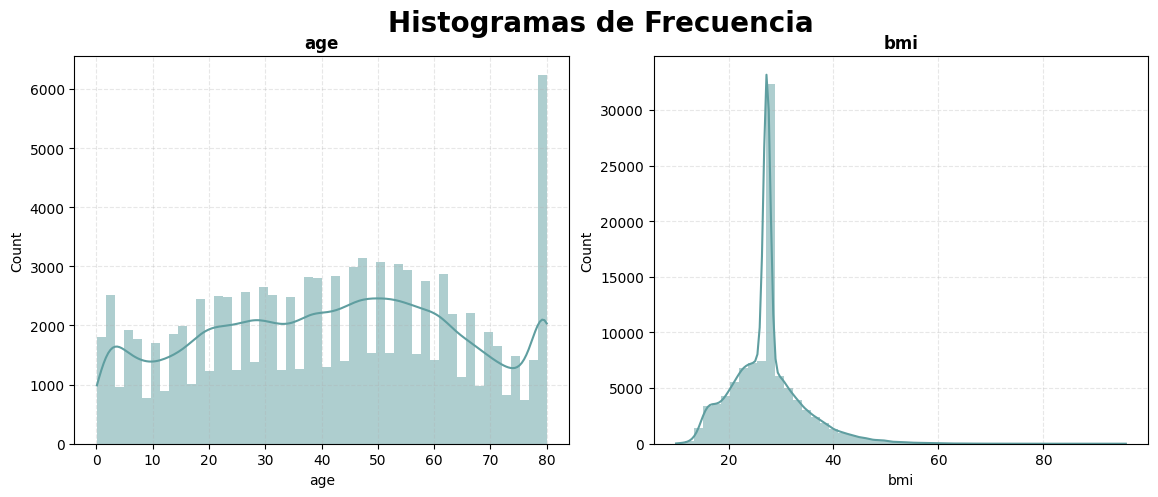

In [10]:
histogramas(data, numeric_features)

+ Como lo pudimos intuir anteriormente, hay una grán cantidad de registros con edad de 80. Las demás edades parecen tener acumulaciones más estables.

+ Observamos una acumulación muy grande de registros con aproximadamente 30 de bmi. Este nivel de bmi ya es considerado sobre peso, por lo que hay una gran cantidad de pacientes con sobrepeso.

## **Feature Engeneering**

## *Edad de 80 años*

Debido a la grán acumulación de datos con edad de 80 sería conveniente observar el impacto que tiene ser una persona de 80 años sobre la probabilidad de tener diabetes

In [11]:
len(data), data[data['age']==80]['age'].count()

(100000, np.int64(5621))

In [12]:
data['diabetes'].mean(), data[data['age']==80]['diabetes'].mean()

(np.float64(0.085), np.float64(0.18217399039316848))

+ Observamos que del total de pacientes el $8.5\%$ tienen diabetes.

+ De únicamente los pacientes con 80 años casi el $20\%$ tiene diabetes, por lo que identificar a los pacientes como un booleano de si pertenece a esa edad o no sería importante.

In [13]:
data['edad_80'] = np.where(data['age']==80, 1, 0)

### Crear variables categóricas del índice de masa corporal

Debido que el bmi del paciente podría impactar en grán medida a la diabetes, sería conveniente crear categorías para que los modelos logren capturar mayor informació de los pacientes. Se dividirán de la siguiente manera:

+ `bajo_peso`: $\text{bmi} < 18.5$
+ `peso_normal`: $18.5 < \text{bmi} < 24.9$
+ `sobrepeso`: $25 < \text{bmi} < 29.9$
+ `obesidad_1` : $30 < \text{bmi} < 34.9$
+ `obesidad_2`: $35 < \text{bmi} < 39.9$
+ `obesidad_3`: $\text{bmi} \geq  40$


In [14]:
data['bajo_peso'] = (data['bmi'] < 18.5).astype(int)
data['normal'] = ((data['bmi'] >= 18.5) & (data['bmi'] < 24.9)).astype(int)
data['sobrepeso'] = ((data['bmi'] >= 25) & (data['bmi'] < 29.9)).astype(int)
data['obesidad_1'] = ((data['bmi'] >= 30) & (data['bmi'] < 34.9)).astype(int)
data['obesidad_2'] = ((data['bmi'] >= 35) & (data['bmi'] < 39.9)).astype(int)
data['obesidad_3'] = (data['bmi'] >= 40).astype(int)

## *Relaciones polinomiales*

Como se vió en el bivariado, la edad tiene una relación cuadrática con el target y bmi aunque no es muy clara, se creará una variable cuadrática por si acaso logra mejorar el modelo.

In [15]:
data['age_2'] = data['age']**2
data['bmi_2'] = data['bmi']**2

# **Modelos iniciales**

En esta sección se comenzará a entrenar modelos `knn_clasificador`, `regresion_logistica`, `red_neuronal`, `discriminante_lineal`, con los datos en crudo si realizar modificaciones para comparar el desempeño de estos modelos.

### Inicializar listas para guardar los resultados

In [16]:
resultados_modelos = []
resultados_auc = []

## *KNN Clasificador*

### Encontrar el número óptimo de vecinos

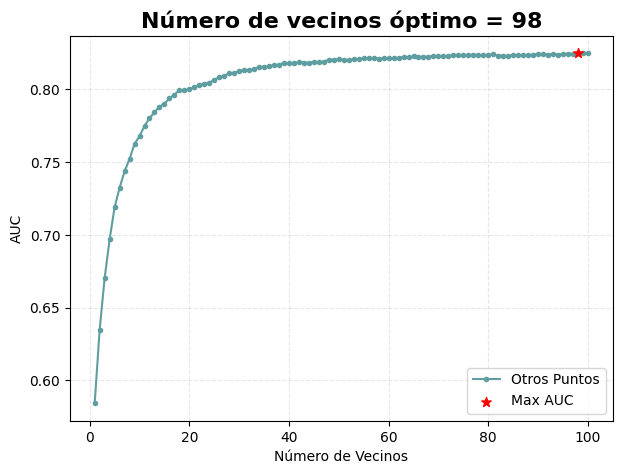

In [17]:
X = data.drop(target, axis=1)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

graph_knn(X_train, X_test, y_train, y_test, 100)

El número óptimo de vecinos es de 98

### Resultados del modelo

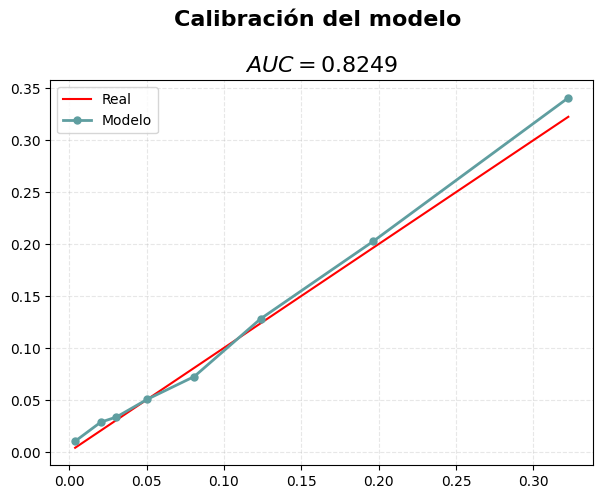

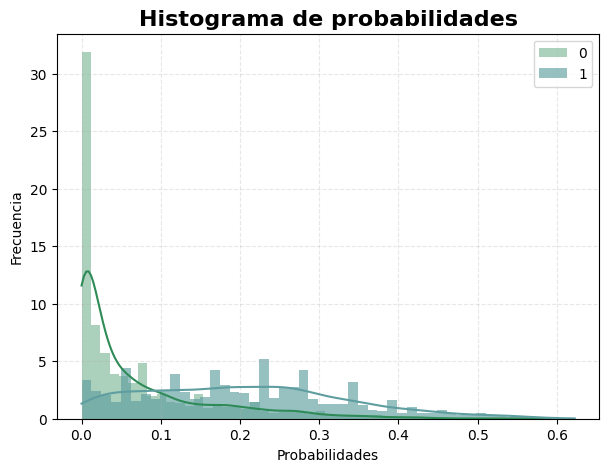

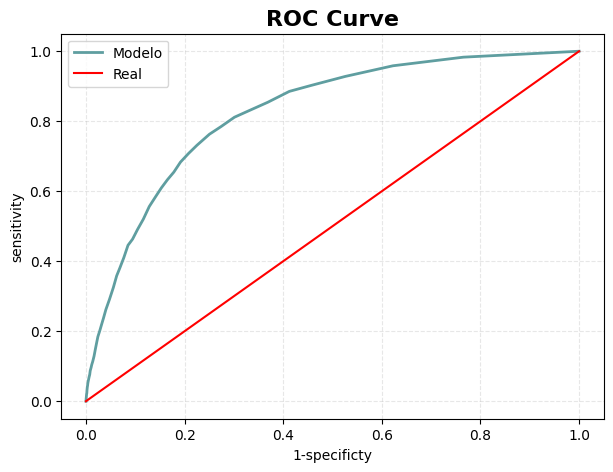

In [18]:
probabilidades, auc = knn_classifier(X_train, X_test, y_train, y_test, 98)
guardar_resultado('KNN_classifier', auc, resultados_modelos, resultados_auc)

plot_results(probabilidades, y_test, 10)

Para ser un modelo de KNN logró un gran resultado, un AUC de 0.8249. La gráfica de calibración muestra un muy buen modelo, sin embargo, poco a poco se desajusta.

El histograma no muestra una separación tan clara al momento de que este modelo clasifica 1 y 0.

## *Regresión logística*

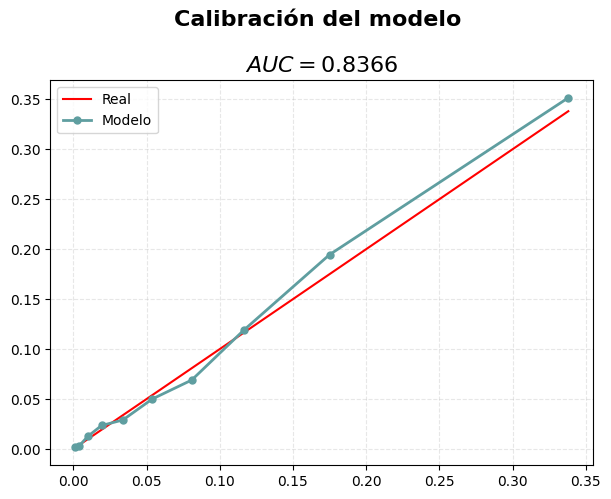

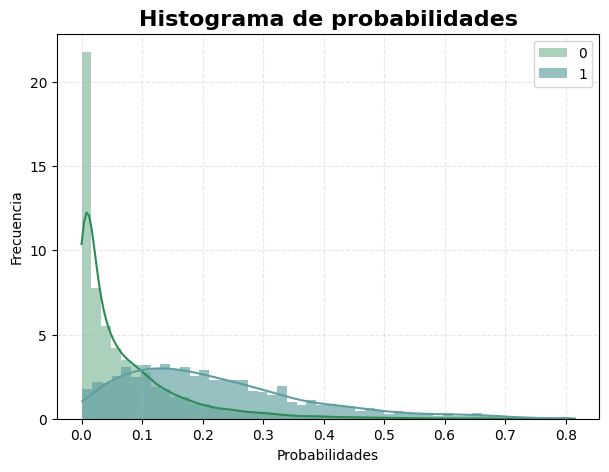

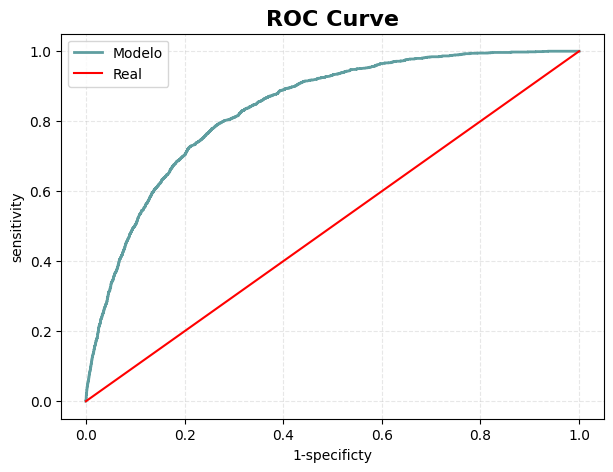

In [19]:
X = data.drop(target, axis=1)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


probabilidades, auc, coef_lr1, variables_lr1 = logistic(X_train, y_train, X_test, y_test, 1)
guardar_resultado('Logistic_regression', auc, resultados_modelos, resultados_auc)
plot_results(probabilidades, y_test, 10)

Mismos comentantarios que con el modelo KNN. El modelo tiene buen ajuste sin embargo tiende a desajustarse poco a poco. Tampoco se logra diferenciar de forma tan clara la clasificaciones de 1 y 0.

## *Regresión logística polinomio grado 2*

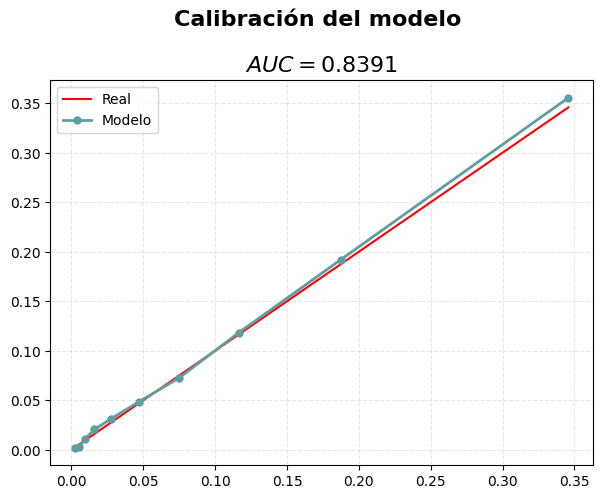

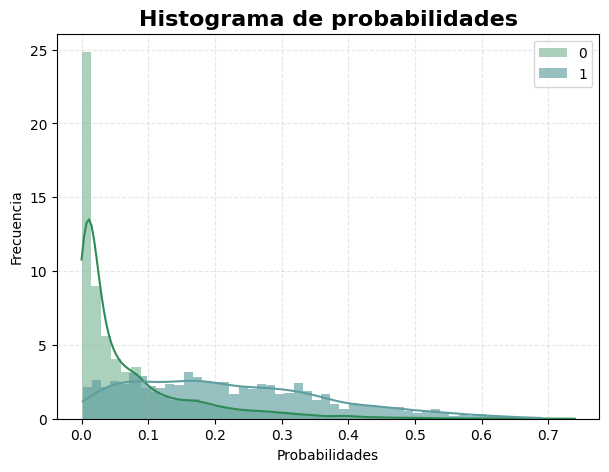

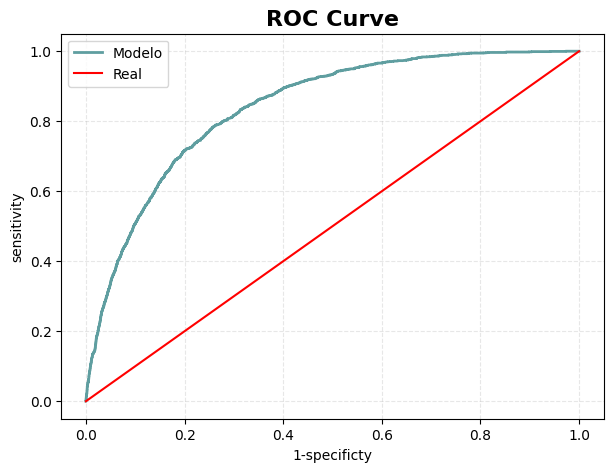

In [20]:
X = data.drop(target, axis=1)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

probabilidades, auc, coef_lr2, variables_lr2 = logistic(X_train, y_train, X_test, y_test, 2)
guardar_resultado('Logistic_regression_poly_2', auc, resultados_modelos, resultados_auc)
plot_results(probabilidades, y_test, 10)

El mejor modelo y calibración hasta el momento. Un AUC de 0.8391. Al igual que los anteriores no se muestra una separación tan clara en el histograma, sin embargo es el mejor modelo hasta ahora.

## *Análisis del discriminante lineal*

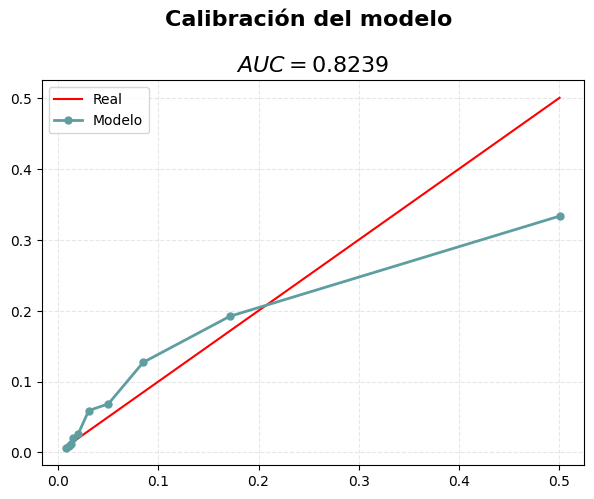

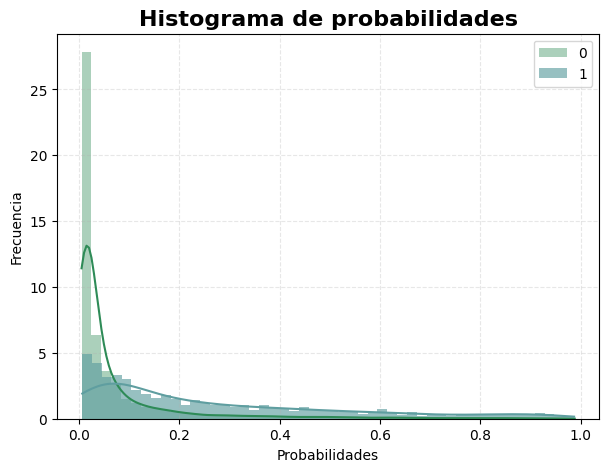

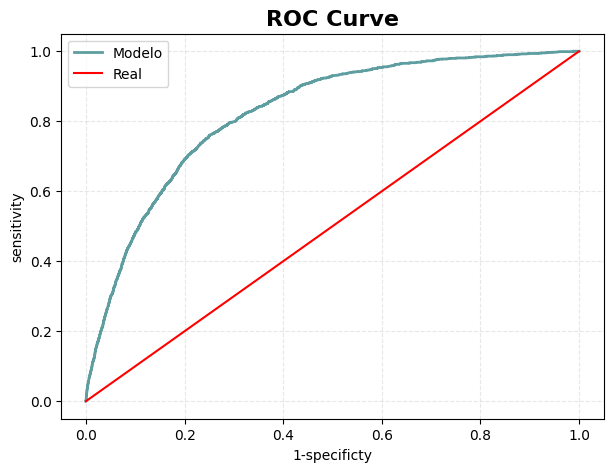

In [21]:
X = data.drop(target, axis=1)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

probabilidades, auc = discriminante(X_train, y_train, X_test, y_test)
guardar_resultado('Linear_discriminant_analysis', auc, resultados_modelos, resultados_auc)
plot_results(probabilidades, y_test, 10)

A pesar de que no tiene un AUC tan malo comparado a los otros modelos, se observa una muy mala calibración así como tambien la peor clasificación observada en el histograma.

## *Red Neuronal*

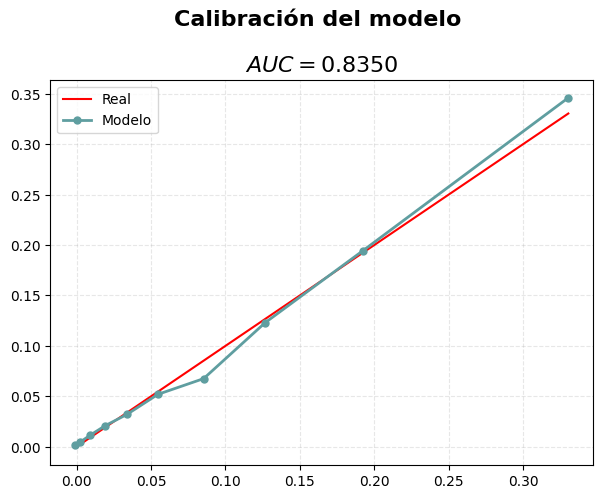

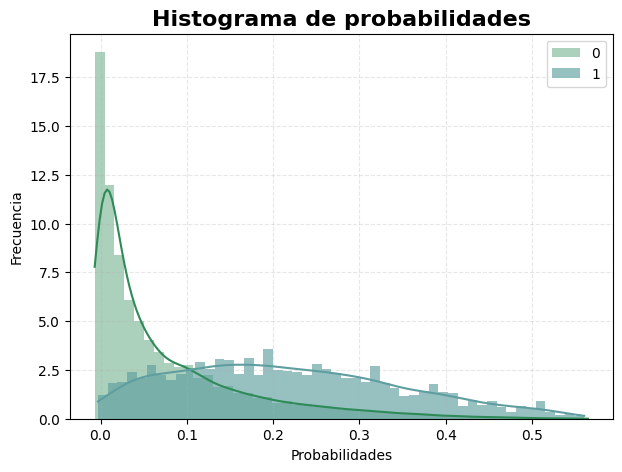

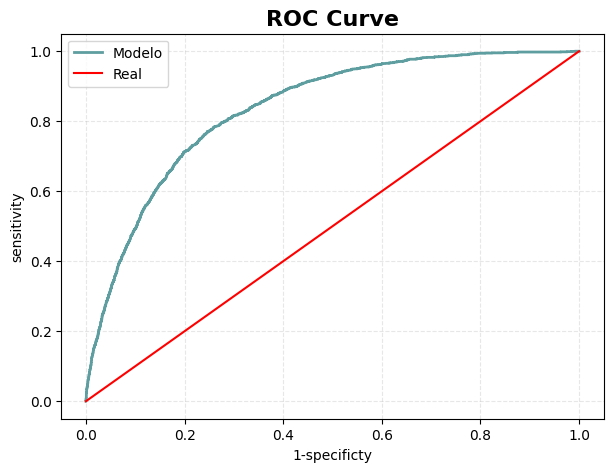

In [22]:
X = data.drop(target, axis=1)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

probabilidades, auc = neural_network(X_train, X_test, y_train, y_test)
guardar_resultado('Neural_Network', auc, resultados_modelos, resultados_auc)
plot_results(probabilidades, y_test, 10)

Tampoco tiene el mejor AUC ni la mejor calibración, sin embargo, en el histograma parece ser el que clasifica mejor. Cabe mencionar que aunque parece tener el mejor histograma, ninguno de los 4 modelos presenta una gran capacidad de separar 1 y 0.

# **Resultados**

## *AUC de los modelos*

In [23]:
pd.DataFrame({
    'Modelo':resultados_modelos,
    'AUC':resultados_auc
}).sort_values(by='AUC', ascending=False)

,Modelo,AUC
2,Logistic_regression_poly_2,0.8391
1,Logistic_regression,0.8366
4,Neural_Network,0.8350
0,KNN_classifier,0.8249
3,Linear_discriminant_analysis,0.8239


+ El mejor modelo obtenido fue una regresión logística polinómica de grado 2 utilizando todas las variables creadas en el feature engeneering junto con las variables originales. 

+ El AUC que se logró obtener fue de 0.8491.

+ Este modelo también mostró la mejor gráfica de calibración de todos los modelos.

+ La capacidad de clasificación del modelo observada en el histograma no es del todo buena, sin embargo fue el mejor modelo.

## *Coeficientes del mejor modelo (regresión logística polinomio grado 2)*

In [24]:
pd.DataFrame({'Variable': variables_lr2, 'Coeficiente': coef_lr2[0]}).sort_values(by='Coeficiente', ascending=False)

,Variable,Coeficiente
20,age_2,0.6587
0,age,0.5800
159,smoking_history_No Info smoking_history_never,0.3012
21,bmi_2,0.2674
105,gender_Female gender_Male,0.2635
...,...,...
104,gender_Female^2,-0.2637
139,gender_Other^2,-0.2722
209,smoking_history_never^2,-0.3347
254,sobrepeso^2,-0.3385


- **`age_2` (0.6587) y `age` (0.5800)**: La edad y edad al cuadrado tienen la mayor importancia e impacto en la probabilidad de tener diabetes. Esto sugiere que a medida que una persona envejece, el riesgo de desarrollar diabetes aumenta, y aumenta en forma exponencial.

- **`smoking_history_No Info smoking_history_never` (0.3012):** Los pacientes cuyo historial de fumar es desconocido o que nunca han fumado tambien tienen un impacto importante incrementando la probabilidad de tener diabetes, cosa que es rara, dado que en teoría serían personas más sanas que los fumadores.  

- **`smoking_history_No Info^2` (-0.4227) y `smoking_history_never^2` (-0.3347)**: Esto es extraño, porque estas mismas variables sin el cuadrado afectan positivamente a la probabilidad de tener diabetes. Sin embargo, estos coeficientes negativos tienen mayor importancia que los que no están al cuadrado, por lo que al final podemos concluir que los que no fuman si decrecen sus probabilidades de tener diabetes.  

- **`sobrepeso^2` (-0.3385):** Otro comportamiento extraño, el sobrepeso al cuadrado está disminuyendo las probabilidades de tener diabetes.

- **`bmi_2` (0.2674):** Observamos que a mayor indice de masa corporal las probabilidades de tener diabetes aumentarán. Además la relación más importante capturada con esta variable es al cuadrado.

# **Conclusiones**

+ Como hemos visto, el mejor modelo fue una regresión logística polinómica de grado 2 utilizando las variables originales y las creadas en el proceso de feature engeneering logrando un AUC de 0.8391.

+ En general todos los modelos mostraron buenas gráficas de calibración.

+ Ninguno de los modelos muestra una grán capacidad de clasificación en los histogramas.

+ Una vez más, y al igual que en el examen pasado, el modelo ganador fue una regresión, ganándo a modelos más complejos como lo son las redes neuronales.

+ Una vez que los datos son analizados a profundidad y creando variables nuevas, los modelos de regresión son capáces de capturar relaciones importantes resultando en modelos más precisos que los modelos más complejos. Además, la regresión tarda únicamente segundos en procesarse, mientras que la red neuronal tardó alrededor de 5 minutos dando un peor resultado.

+ Creo que las redes neuronales son una excelente opción para obtener un modelo robusto que capture relaciones importantes entre las variables cuando no se tiene el tiempo suficiente para analizar los datos que se tienen. Sin embargo, luego de un buen estudio se puede lograr lo mismo con modelos más sencillos y que son más ligeros computacionalmente como las regresiones.